In [149]:
# save in JSON format

import numpy as np
import os
import json
from tqdm import tqdm 
# import csv

dataset_folder = "/media/giancos/Football/dataset_crop224/"

labels = ["background", "card", "substitution", "goal"]

In [150]:
# GET CANDIDATE SPOT FROM ARGMAX
def get_spot_from_Argmax(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_max = np.zeros(len(t_end))
    for i in range(len(t_end)):
#         score[i] = np.mean(array[t_init[i]:t_end[i]])
        t_max[i] = t_init[i] + np.argmax(array[t_init[i]:t_end[i]])
        score[i] = array[int(t_max[i])]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_max, score])


data = {}
data["version"] = "VERSION 1.3"
data["results"] = {}
for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
    for Half in [1,2]:
        predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
        KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
        data["results"][KeyGame] = {}
        data["results"][KeyGame] = []
        for l in range(1,4):
            spots = get_spot_from_Argmax(predictions[:,l])
            for spot in spots:
                result = {"label":labels[l], "segment":[int(spot[0]), int(spot[0]+1)], "score":spot[1]}
                data["results"][KeyGame].append(result)


with open("Results_Spot/predictions_Argmax.json", 'w') as f:
    json.dump(data, f, indent = 4)


In [153]:
# GET CANDIDATE SPOT FROM CENTER
def get_spot_from_Center(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_spot = np.zeros(len(t_end))
    for i in range(len(t_end)):
#         score[i] = np.mean(array[t_init[i]:t_end[i]])
        t_spot[i] = (t_init[i] + t_end[i]) / 2
        score[i] = array[int(t_spot[i])]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_spot, score])


data = {}
data["version"] = "VERSION 1.3"
data["results"] = {}
for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
    for Half in [1,2]:
        predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
        KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
        data["results"][KeyGame] = {}
        data["results"][KeyGame] = []
        for l in range(1,4):
            spots = get_spot_from_Center(predictions[:,l])
            for spot in spots:
                result = {"label":labels[l], "segment":[int(spot[0]), int(spot[0]+1)], "score":spot[1]}
                data["results"][KeyGame].append(result)


with open("Results_Spot/predictions_Center.json", 'w') as f:
    json.dump(data, f, indent = 4)

In [157]:
# GET CANDIDATE SPOT FROM NMS
import numpy as np
def get_spot_from_NMS(Input, window=60):

    res = np.empty(np.size(Input), dtype=bool)
#     print(np.size(Input))
#     print(res.shape)
    for i, value  in enumerate(Input):
        if (i<=window/2 or i>=np.size(Input)-window/2):
            res[i] = False
            continue
#         print(i,value)
#         if value > Input[i-1] and value > Input[i+1]:
#         print(np.max(Input[(i-int(window/2)):(i+int(window/2))]))
#         if value == np.max(Input[(i-int(window/2)):(i+int(window/2))]):
        if value >= np.max(Input[i+1:(i+int(window/2))]) and \
            value > np.max(Input[(i-int(window/2)):i]) and \
            value > 0.5:
            res[i] = True
        else:
#             print (Input[i-1], value, Input[i+1])
            res[i] = False
#             for past in range(int(window/2)):
#                 if (i-past < 0) : continue
#                 if (res[i-past] == True and Input[i-past] > Input[i]) : 
#                     res[i] = False
#                     break
#                 if (res[i-past] == True and Input[i-past] < Input[i]) :
#                     res[i-past] = False
#     res = np.r_[True, Input[1:] > Input[:-1]] & np.r_[Input[:-1] > Input[1:], True]
    res[0] = False
    res[-1] = False
#     print(res)
    
    MaxValues = Input[res==True]
#     print(MaxValues)
    indexes = np.arange(np.size(Input))[res==True]
    return indexes, MaxValues


Input = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  9, 8,  9, 10, 11, 12, 13, 14, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 0])

print((Input))
indexes, scores = get_spot_from_NMS(Input*0.1,window=6)
# print( output)
print("indexes:", indexes)
print("scores:", scores)

# np.r_[True, Input[1:] < Input[:-1]] & np.r_[Input[:-1] < Input[1:], True]


[ 0  1  2  3  4  5  6  7  8  9 10  9  8  9 10 11 12 13 14 15 14 13 12 11 10
  9  8  7  6  5  4  3  2  1  0]
indexes: [10 19]
scores: [ 1.   1.5]


In [158]:
data = {}
data["version"] = "VERSION 1.3"
data["results"] = {}
for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
    for Half in [1,2]:
        predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
        KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
        data["results"][KeyGame] = {}
        data["results"][KeyGame] = []
        for l in range(1,4):
            Input = predictions[:,l]
            indexes, scores = get_spot_from_NMS(Input)
#             print(spots)
            for i in range(len(indexes)):
                spot = indexes[i]
                score = scores[i]
#                 if (score > 0.5):
#                 print(spot)
                result = {"label":labels[l], "segment":[int(spot), int(spot+1)], "score":float(score)}
                data["results"][KeyGame].append(result)                
#                 print(json.dumps(result))


with open("Results_Spot/predictions_NMS.json", 'w') as f:
    json.dump(data, f, indent = 4)

In [37]:

Input = np.arange(1,20)
Input= np.append(Input, np.arange(20,1,-1))
Input= np.append(Input, np.arange(1,110))
Input= np.append(Input, np.arange(110,1,-1))

print((Input))
print("indexes:", get_spot_from_NMS(Input*0.001,window=2)[0])
print("scores:", get_spot_from_NMS(Input*0.001,window=2)[1])


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  19  18  17  16  15  14  13  12  11  10   9   8   7   6   5   4
   3   2   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 109 108 107 106 105 104 103 102 101 100  99  98  97  96
  95  94  93  92  91  90  89  88  87  86  85  84  83  82  81  80  79  78
  77  76  75  74  73  72  71  70  69  68  67  66  65  64  63  62  61  60
  59  58  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42
  41  40  39  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24
  23  22  21  20  19  18  17  16  15  14  13  12  1

In [75]:
# GET CANDIDATE SEGMENT FROM A GIVEN THRESHOLD
def get_border_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    for i in range(len(t_end)):
        score[i] = np.mean(array[t_init[i]:t_end[i]])
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end, score])


for WaterShedThresh in tqdm(range(95,0,-5)):
#     print(WaterShedThresh)
    data = {}
    data["version"] = "VERSION 1.3"
    data["results"] = {}
    for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
        for Half in [1,2]:
            predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
            KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
            data["results"][KeyGame] = {}
            data["results"][KeyGame] = []
            for l in range(1,4):
                segments = get_border_with_score(predictions[:,l], thresh=WaterShedThresh/100)
                for segment in segments:
                    if (int(segment[1]) - int(segment[0]) > 240):
                        print( "segment", segment)
                    result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":segment[2]}
#                     result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":WaterShedThresh/100}
                    data["results"][KeyGame].append(result)


    with open("Results/predictions_Thesh_"+str(WaterShedThresh)+".json", 'w') as f:
        json.dump(data, f, indent = 4)
        

100%|██████████| 19/19 [00:06<00:00,  2.87it/s]


In [82]:
# GET GROUND TRHUTGH
def get_GT(event, Delta):
    """ Return the GT Labels Segment for a given event"""
    Half = int(event["gameTime"][0])
    Time_Minute = int(event["gameTime"][-5:-3])
    Time_Second = int(event["gameTime"][-2:])       
    if ("card" in event["label"]): l = 1
    elif ("subs" in event["label"]): l = 2
    elif ("soccer" in event["label"]): l = 3
    else: l = 0
    t_ini = Time_Minute*60+Time_Second-int(Delta/2)
    t_end = Time_Minute*60+Time_Second+int(Delta/2)
    return Half, t_ini, t_end, l
   
    
    
for DeltaGT in range(120,0,-5):
    print(DeltaGT)
    data = {}
    data["database"] = {}
    for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
        for Half in [1,2]:

            KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
            data["database"][KeyGame] = {}
            data["database"][KeyGame]["annotations"] = []
            data["database"][KeyGame]["duration"] = 0
            data["database"][KeyGame]["resolution"] = "0x0"
            data["database"][KeyGame]["subset"] = "validation"
            data["database"][KeyGame]["url"] = "https://pippo.com"

            with open(os.path.join(dataset_folder, Game, "Labels.json")) as labelFile :
                jsonLabel = json.loads(labelFile.read())
                for event in jsonLabel["annotations"]:
                    Half_event, t_ini, t_end, i_label = get_GT(event, DeltaGT)
                    
                    if (i_label == 0):
                        break
                        
                    if (Half_event == Half):
                        data["database"][KeyGame]["annotations"].append({"label":labels[i_label], "segment":[int(t_ini), int(t_end)]})



    with open("Results/labels_Delta_"+str(DeltaGT)+".json", 'w') as f:
        json.dump(data, f, indent = 4)


        

120
115
110
105
100
95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5


In [8]:
# save in JSON format

import numpy as np
import os
import json
# import csv

dataset_folder = "/media/giancos/Football/dataset_crop224/"

labels = ["background", "card", "substitution", "goal"]


def get_time_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_center = np.zeros(t_init.shape)
    for i in range(len(t_end)):
        score[i] = np.mean(array[t_init[i]:t_end[i]])
#         print(np.argmax(array[t_init[i]:t_end[i]]))
        t_center[i] = t_init[i] + np.argmax(array[t_init[i]:t_end[i]])
    segment_predictions = np.transpose([t_init, t_end])
#     print (np.transpose([t_init, t_center, t_end, score]))
    return  np.transpose([t_center, score])


for WaterShedThresh in range(95,0,-5):
    for delta in range(60,0,-5):

#         WaterShedThresh = 0.5
        print(WaterShedThresh, delta)
        data = {}
        data["version"] = "VERSION 1.3"
        data["results"] = {}
        for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
            for Half in [1,2]:
                predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
                KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
                data["results"][KeyGame] = {}
                data["results"][KeyGame] = []
                for l in range(1,4):
                    segments = get_time_with_score(predictions[:,l], thresh=WaterShedThresh/100)
                    for segment in segments:
                        if (int(segment[1]) - int(segment[0]) > 240):
                            print( "segment", segment)
                        result = {"label":labels[l], "segment":[int(segment[0]-delta/2), int(segment[0]+delta/2)], "score":segment[1]}
        #                     result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":WaterShedThresh/100}
                        data["results"][KeyGame].append(result)


        with open("Results/predictions_Thresh_" + str(WaterShedThresh) + "_Delta_" + str(delta) + "_ArgMax.json", 'w') as f:
            json.dump(data, f, indent = 4)



        

95 60
95 55
95 50
95 45
95 40
95 35
95 30
95 25
95 20
95 15
95 10
95 5
90 60
90 55
90 50
90 45
90 40
90 35
90 30
90 25
90 20
90 15
90 10
90 5
85 60
85 55
85 50
85 45
85 40
85 35
85 30
85 25
85 20
85 15
85 10
85 5
80 60
80 55
80 50
80 45
80 40
80 35
80 30
80 25
80 20
80 15
80 10
80 5
75 60
75 55
75 50
75 45
75 40
75 35
75 30
75 25
75 20
75 15
75 10
75 5
70 60
70 55
70 50
70 45
70 40
70 35
70 30
70 25
70 20
70 15
70 10
70 5
65 60
65 55
65 50
65 45
65 40
65 35
65 30
65 25
65 20
65 15
65 10
65 5
60 60
60 55
60 50
60 45
60 40
60 35
60 30
60 25
60 20
60 15
60 10
60 5
55 60
55 55
55 50
55 45
55 40
55 35
55 30
55 25
55 20
55 15
55 10
55 5
50 60
50 55
50 50
50 45
50 40
50 35
50 30
50 25
50 20
50 15
50 10
50 5
45 60
45 55
45 50
45 45
45 40
45 35
45 30
45 25
45 20
45 15
45 10
45 5
40 60
40 55
40 50
40 45
40 40
40 35
40 30
40 25
40 20
40 15
40 10
40 5
35 60
35 55
35 50
35 45
35 40
35 35
35 30
35 25
35 20
35 15
35 10
35 5
30 60
30 55
30 50
30 45
30 40
30 35
30 30
30 25
30 20
30 15
30 10
30 5
25 60


In [9]:
# save in JSON format

import numpy as np
import os
import json
# import csv

dataset_folder = "/media/giancos/Football/dataset_crop224/"

labels = ["background", "card", "substitution", "goal"]


def get_time_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_center = np.zeros(t_init.shape)
    for i in range(len(t_end)):
        score[i] = np.mean(array[t_init[i]:t_end[i]])
#         print(np.argmax(array[t_init[i]:t_end[i]]))
        t_center[i] = (t_init[i] + t_end[i] ) / 2
    segment_predictions = np.transpose([t_init, t_end])
#     print (np.transpose([t_init, t_center, t_end, score]))
    return  np.transpose([t_center, score])


for WaterShedThresh in range(95,0,-5):
    for delta in range(60,0,-5):

#         WaterShedThresh = 0.5
        print(WaterShedThresh, delta)
        data = {}
        data["version"] = "VERSION 1.3"
        data["results"] = {}
        for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
            for Half in [1,2]:
                predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
                KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
                data["results"][KeyGame] = {}
                data["results"][KeyGame] = []
                for l in range(1,4):
                    segments = get_time_with_score(predictions[:,l], thresh=WaterShedThresh/100)
                    for segment in segments:
                        if (int(segment[1]) - int(segment[0]) > 240):
                            print( "segment", segment)
                        result = {"label":labels[l], "segment":[int(segment[0]-delta/2), int(segment[0]+delta/2)], "score":segment[1]}
        #                     result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":WaterShedThresh/100}
                        data["results"][KeyGame].append(result)


        with open("Results/predictions_Thresh_" + str(WaterShedThresh) + "_Delta_" + str(delta) + "_Center.json", 'w') as f:
            json.dump(data, f, indent = 4)




95 60
95 55
95 50
95 45
95 40
95 35
95 30
95 25
95 20
95 15
95 10
95 5
90 60
90 55
90 50
90 45
90 40
90 35
90 30
90 25
90 20
90 15
90 10
90 5
85 60
85 55
85 50
85 45
85 40
85 35
85 30
85 25
85 20
85 15
85 10
85 5
80 60
80 55
80 50
80 45
80 40
80 35
80 30
80 25
80 20
80 15
80 10
80 5
75 60
75 55
75 50
75 45
75 40
75 35
75 30
75 25
75 20
75 15
75 10
75 5
70 60
70 55
70 50
70 45
70 40
70 35
70 30
70 25
70 20
70 15
70 10
70 5
65 60
65 55
65 50
65 45
65 40
65 35
65 30
65 25
65 20
65 15
65 10
65 5
60 60
60 55
60 50
60 45
60 40
60 35
60 30
60 25
60 20
60 15
60 10
60 5
55 60
55 55
55 50
55 45
55 40
55 35
55 30
55 25
55 20
55 15
55 10
55 5
50 60
50 55
50 50
50 45
50 40
50 35
50 30
50 25
50 20
50 15
50 10
50 5
45 60
45 55
45 50
45 45
45 40
45 35
45 30
45 25
45 20
45 15
45 10
45 5
40 60
40 55
40 50
40 45
40 40
40 35
40 30
40 25
40 20
40 15
40 10
40 5
35 60
35 55
35 50
35 45
35 40
35 35
35 30
35 25
35 20
35 15
35 10
35 5
30 60
30 55
30 50
30 45
30 40
30 35
30 30
30 25
30 20
30 15
30 10
30 5
25 60


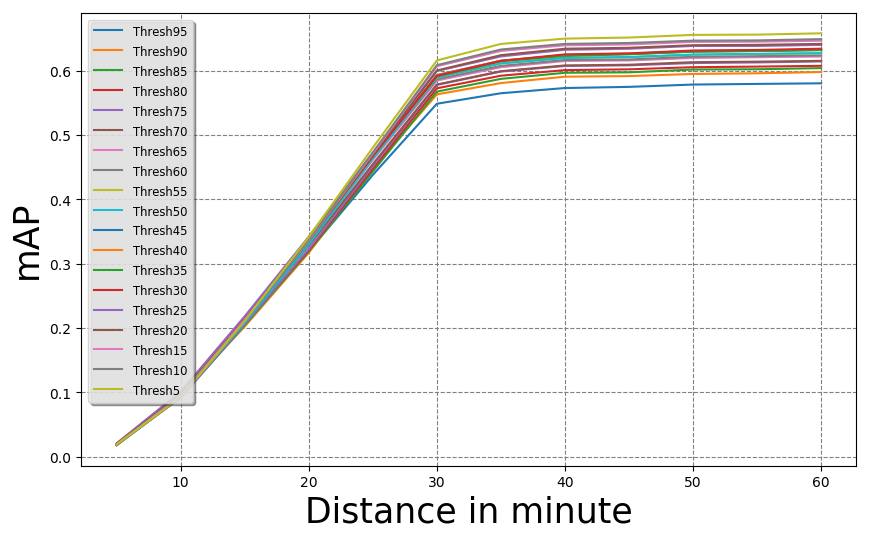

In [68]:

from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

import numpy as np
import matplotlib


fig, ax = plt.subplots(num=None, 
                       figsize=(10, 6), 
                       dpi=100, 
                       facecolor='w',
                       edgecolor='k')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

for j, Thresh in enumerate(range(95,0,-5)):
    try:
        res = np.load("Evaluation/Metric2_Tresh_"+str(Thresh)+"_ArgMax.npy")
        ax.plot(np.arange(60,0,-5), res, label='Thresh'+str(Thresh))
    except:
        print(Thresh, "missing")
        
legend = ax.legend(loc='upper left', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.95')


# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

    
plt.ylabel("mAP", fontsize=25)
plt.xlabel("Distance in minute", fontsize=25)
plt.show()
folder = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Results/"

# fig.savefig(folder + 'GraphDetection_metric2_ArgMax.png',bbox_inches='tight')



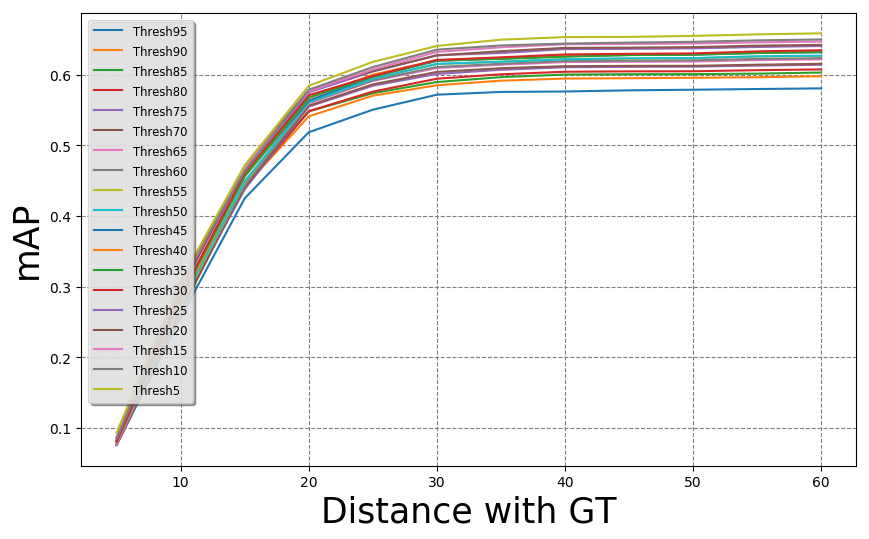

In [69]:

from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

import numpy as np
import matplotlib


fig, ax = plt.subplots(num=None, 
                       figsize=(10, 6), 
                       dpi=100, 
                       facecolor='w',
                       edgecolor='k')

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

for j, Thresh in enumerate(range(95,0,-5)):
    try:
        res = np.load("Evaluation/Metric2_Tresh_"+str(Thresh)+"_Center.npy")
#         print(res)
        ax.plot(np.arange(60,0,-5), res, label='Thresh'+str(Thresh))
    except:
        print(Thresh, "missing")
        
legend = ax.legend(loc='upper left', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.95')


# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

    
plt.ylabel("mAP", fontsize=25)
plt.xlabel("Distance with GT", fontsize=25)
plt.show()
folder = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Results/"

# fig.savefig(folder + 'GraphDetection_metric2_Center.png',bbox_inches='tight')


In [17]:
import os
import numpy as np
import json

dataset_folder = "/media/giancos/Football/dataset_crop224/"

labels = ["background", "card", "substitution", "goal"]

def get_GT(event, Delta):
    """ Return the GT Labels Segment for a given event"""
    Half = int(event["gameTime"][0])
    Time_Minute = int(event["gameTime"][-5:-3])
    Time_Second = int(event["gameTime"][-2:])       
    if ("card" in event["label"]): l = 1
    elif ("subs" in event["label"]): l = 2
    elif ("soccer" in event["label"]): l = 3
    else: l = 0
    t_ini = Time_Minute*60+Time_Second-int(Delta/2)
    t_end = Time_Minute*60+Time_Second+int(Delta/2)
    return Half, t_ini, t_end, l
   
    

data = {}
data["database"] = {}
for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
    for Half in [1,2]:

        KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
        data["database"][KeyGame] = {}
        data["database"][KeyGame]["annotations"] = []
        data["database"][KeyGame]["duration"] = 0
        data["database"][KeyGame]["resolution"] = "0x0"
        data["database"][KeyGame]["subset"] = "validation"
        data["database"][KeyGame]["url"] = "https://pippo.com"

        with open(os.path.join(dataset_folder, Game, "Labels.json")) as labelFile :
            jsonLabel = json.loads(labelFile.read())
            for event in jsonLabel["annotations"]:
                Half_event, t_ini, t_end, i_label = get_GT(event, 0)

                if (i_label == 0):
                    break

                if (Half_event == Half):
                    data["database"][KeyGame]["annotations"].append({"label":labels[i_label], 
                                                                     "event":int(t_ini)})



with open("Results/labels.json", 'w') as f:
    json.dump(data, f, indent = 4)
        
        
        
def get_time_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_center = np.zeros(t_init.shape)
    for i in range(len(t_end)):
        score[i] = np.mean(array[t_init[i]:t_end[i]])
#         print(np.argmax(array[t_init[i]:t_end[i]]))
        t_center[i] = (t_init[i] + t_end[i] ) / 2
    segment_predictions = np.transpose([t_init, t_end])
#     print (np.transpose([t_init, t_center, t_end, score]))
    return  np.transpose([t_center, score])




for WaterShedThresh in range(95,0,-5):

#         WaterShedThresh = 0.5
    print(WaterShedThresh)
    data = {}
    data["version"] = "VERSION 1.3"
    data["results"] = {}
    for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
        for Half in [1,2]:
            predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
            KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
            data["results"][KeyGame] = {}
            data["results"][KeyGame] = []
            for l in range(1,4):
                segments = get_time_with_score(predictions[:,l], thresh=WaterShedThresh/100)
                for segment in segments:
                    result = {"label":labels[l], "event":segment[0], "score":segment[1]}
                    data["results"][KeyGame].append(result)


    with open("Results/predictions_Thresh_" + str(WaterShedThresh) + "_Center.json", 'w') as f:
        json.dump(data, f, indent = 4)



95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5


In [55]:
WaterShedThresh = 95
with open("Results/labels.json", 'r') as f_GT:
    parsed_GT = json.load(f_GT)
    with open("Results/predictions_Thresh_" + str(WaterShedThresh) + "_Center.json", 'r') as f:
        parsed = json.load(f)
        f_GT
    #     print(json.dumps(parsed, indent=4))
        for game in parsed["results"]:
            print(game)
            t_card=[]
            t_subs=[]
            t_goal=[]
            for candidate in parsed["results"][game]:
                if(candidate["label"] == "card"): t_card.append(candidate["event"])
                if(candidate["label"] == "substitution"): t_subs.append(candidate["event"])
                if(candidate["label"] == "goal"): t_goal.append(candidate["event"])
            print(t_card)
            print(t_subs)
            print(t_goal)
#             print(json.dumps(parsed["results"][game], indent=4))
            
            Gt_card=[]
            Gt_subs=[]
            Gt_goal=[]
            for GT in parsed_GT["database"][game]["annotations"]:
                if(GT["label"] == "card"): Gt_card.append(GT["event"])
                if(GT["label"] == "substitution"): Gt_subs.append(GT["event"])
                if(GT["label"] == "goal"): Gt_goal.append(GT["event"])
            print(Gt_card)
            print(Gt_subs)
            print(Gt_goal)
            
            
            
            
#             print(json.dumps(parsed_GT["database"][game]["annotations"], indent=4))

2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal_Half_1.npy
[1561.5, 2154.0, 2433.0, 2449.0, 2471.0]
[]
[1774.0]
[]
[]
[1759]
2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal_Half_2.npy
[1750.5, 1770.0, 2980.0, 3016.5]
[915.0, 1612.5, 1686.0, 2671.5, 2686.5]
[]
[2994]
[929, 1610, 1632, 1674, 1741, 2693]
[2194]
2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea_Half_1.npy
[694.5, 697.0, 1380.5, 1947.5, 1974.0, 1995.5, 2770.5]
[4.0]
[1867.5]
[1980, 2780]
[]
[1860]
2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea_Half_2.npy
[146.5, 363.0, 2138.0, 2753.5]
[1115.5, 1191.5, 1998.5, 2277.0]
[2032.0, 2360.0]
[132, 356, 2130, 2750]
[0, 1115, 1198, 1995, 2008, 2278]
[2023, 2352]
2015-08-23 - 15-30 West Brom 2 - 3 Chelsea_Half_1.npy
[959.0, 990.0, 2171.5]
[]
[766.0, 790.0, 805.5, 1156.0, 1163.5, 1191.5, 1734.5, 1746.0, 2507.0]
[]
[]
[]
2015-08-23 - 15-30 West Brom 2 - 3 Chelsea_Half_2.npy
[270.5, 422.0, 500.5, 670.0, 1273.5, 1508.0, 1536.5, 2651.0, 2659.0]
[602.0, 616.0, 844.0, 879.0, 887.5, 19

In [88]:
import numpy as np
import json
import os


In [111]:
def segment_iou(target_segment, candidate_segments):
    """Compute the temporal intersection over union between a
    target segment and all the test segments.
    Parameters
    ----------
    target_segment : 1d array
        Temporal target segment containing [starting, ending] times.
    candidate_segments : 2d array
        Temporal candidate segments containing N x [starting, ending] times.
    Outputs
    -------
    tiou : 1d array
        Temporal intersection over union score of the N's candidate segments.
    """
    tt1 = np.maximum(target_segment[0], candidate_segments[:, 0])
    tt2 = np.minimum(target_segment[1], candidate_segments[:, 1])
    # Intersection including Non-negative overlap score.
    segments_intersection = (tt2 - tt1).clip(0)
    # Segment union.
    segments_union = (candidate_segments[:, 1] - candidate_segments[:, 0]) \
      + (target_segment[1] - target_segment[0]) - segments_intersection
    # Compute overlap as the ratio of the intersection
    # over union of two segments.
    tIoU = segments_intersection.astype(float) / segments_union
    return tIoU

def wrapper_segment_iou(target_segments, candidate_segments):
    """Compute intersection over union btw segments
    Parameters
    ----------
    target_segments : ndarray
        2-dim array in format [m x 2:=[init, end]]
    candidate_segments : ndarray
        2-dim array in format [n x 2:=[init, end]]
    Outputs
    -------
    tiou : ndarray
        2-dim array [n x m] with IOU ratio.
    Note: It assumes that candidate-segments are more scarce that target-segments
    """
    if candidate_segments.ndim != 2 or target_segments.ndim != 2:
        raise ValueError('Dimension of arguments is incorrect')

    n, m = candidate_segments.shape[0], target_segments.shape[0]
    tiou = np.empty((n, m))
    for i in range(m):
        tiou[:, i] = segment_iou(target_segments[i,:], candidate_segments)

    return tiou

In [112]:
dataset_folder = "/media/giancos/Football/dataset_crop224/"
game_folder = os.path.join(dataset_folder, "england_epl/2015-2016/2015-09-12 - 14-45 Everton 3 - 1 Chelsea")


In [113]:
prediction_filename = os.path.join(game_folder, "Predictions_Half_1.npy")
predictions = np.load(prediction_filename)
# print(predictions.shape)
# print(predictions)

def get_border(array, thresh=0.5):
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end])
    

    
# print(get_border(np.array([.8,.6,.7,.8,.2,.1,.3,.6,.7,.9,.1])))

segment_predictions2 = np.array(get_border(predictions[:,3],0.8))
print(segment_predictions2)

[[ 351  367]
 [ 369  381]
 [ 952 1010]
 [1262 1337]
 [1494 1504]
 [1513 1517]
 [2086 2151]]


In [114]:
segments_labels = []
size_window_label = 60
with open(os.path.join(game_folder, "Labels.json")) as labelFile :
    jsonLabel = json.loads(labelFile.read())

    labels = np.zeros((predictions.shape[0],4), dtype=int)
    labels[:,0] = 1


    for event in jsonLabel["annotations"]:
        Half = int(event["gameTime"][0])
        Time_Minute = int(event["gameTime"][-5:-3])
        Time_Second = int(event["gameTime"][-2:])

#         if ("card" in event["label"]):
#         if ("subs" in event["label"]): 
        if ("soccer" in event["label"]): 
        # else: print("err in event Label", event["label"])

            if ("Half_" + str(Half) in prediction_filename):
                aroundValue = min(Time_Minute*60+Time_Second, labels.shape[0]-1)
    #             labels[(aroundValue-int(size_window_label/2)):(aroundValue+int(size_window_label/2)), 0] = 0
    #             labels[(aroundValue-int(size_window_label/2)):(aroundValue+int(size_window_label/2)), l] = 1

                segments_labels.append([aroundValue-int(size_window_label/2), (aroundValue+int(size_window_label/2))])

            
            
segments_labels = np.array(segments_labels)
# print(labels.shape)
# print(labels)
print(segments_labels)

# print((predictions>0.5) - labels)

[[ 947 1007]
 [1250 1310]
 [2080 2140]]


In [151]:

def get_border(array, thresh=0.5):
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end])



dataset_folder = "/media/giancos/Football/dataset_crop224/"

labels = ["back","card","subs","soccer"]
print(labels[cl])
if (str(labels[2]) in "soccer_ppipip"):
    print("good")


cl = 3

Threshold_Water_Shred = 0.1
Delta = 60

tIoU = 0.5



for game in np.load(os.path.join(dataset_folder,"listgame.npy")):
    for Half in [1,2]:
        game_folder = os.path.join(dataset_folder, game)





        # get Prediction
        prediction_filename = os.path.join(game_folder, "Predictions_Half_"+str(Half)+".npy")
        predictions = np.load(prediction_filename)




        # print(get_border(np.array([.8,.6,.7,.8,.2,.1,.3,.6,.7,.9,.1])))

        segment_predictions = np.array(get_border(predictions[:,cl],Threshold_Water_Shred))
#         print(segment_predictions3)







        segments_labels = []
        size_window_label = 60
        with open(os.path.join(game_folder, "Labels.json")) as labelFile :
            jsonLabel = json.loads(labelFile.read())

            labels = np.zeros((predictions.shape[0],4), dtype=int)
            labels[:,0] = 1


            for event in jsonLabel["annotations"]:
                Half = int(event["gameTime"][0])
                Time_Minute = int(event["gameTime"][-5:-3])
                Time_Second = int(event["gameTime"][-2:])

        #         if ("card" in event["label"]):
        #         if ("subs" in event["label"]): 
                if (str(labels[cl]) in event["label"]): 
                # else: print("err in event Label", event["label"])

                    if ("Half_" + str(Half) in prediction_filename):
                        aroundValue = min(Time_Minute*60+Time_Second, labels.shape[0]-1)
            #             labels[(aroundValue-int(size_window_label/2)):(aroundValue+int(size_window_label/2)), 0] = 0
            #             labels[(aroundValue-int(size_window_label/2)):(aroundValue+int(size_window_label/2)), l] = 1

                        segments_labels.append([aroundValue-int(size_window_label/2), (aroundValue+int(size_window_label/2))])



        segments_labels = np.array(segments_labels)
        # print(labels.shape)
        # print(labels)
        print(segments_labels)

        # print((predictions>0.5) - labels)







        # for i in Videos:

#         if ((len(segments_labels) > 0) and (len(segment_predictions3) > 0)):
        score = wrapper_segment_iou(segments_labels, segment_predictions3)
        # tiou = 0.7
        print(score)
        TP += (np.count_nonzero(np.max(score,axis=1) > tIoU))
        FP += (np.count_nonzero(np.max(score,axis=1) < tIoU))
        FN += (np.count_nonzero(np.max(score,axis=0) < tIoU))

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
true_positives_tiou = score >= tIoU
print(np.count_nonzero((true_positives_tiou[:, :]).sum(axis=1)))

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("Precision", Precision)
print("Recall", Recall)

soccer
[]


ValueError: Dimension of arguments is incorrect

In [267]:
csv_file = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Results/Results_Detection.csv"
df = pd.read_csv(csv_file, index_col=0)

In [268]:
df.set_value(55,str(45),2.0)


,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
for i, DeltaGT in enumerate(range(60,0,-5)):
    for j, WaterShedThresh in enumerate(range(95,0,-5)):
        csv_file = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Results/Results_Detection.csv"
        df =  pd.read_csv(csv_file, index_col=0)
        # df =
        df.set_value(DeltaGT,str(WaterShedThresh),1.0)
        # print(model)
        # df.set_value(args.jobid,"model",model)
        df.to_csv(csv_file, sep=',', encoding='utf-8')

In [192]:
def get_border_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score  = np.mean(array[t_ini:t_end])
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end, score])

def get_border(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end])

def get_GT(event, Delta):
    """ Return the GT Labels Segment for a given event"""
    Half = int(event["gameTime"][0])
    Time_Minute = int(event["gameTime"][-5:-3])
    Time_Second = int(event["gameTime"][-2:])       
    if ("card" in event["label"]): l = 1
    elif ("subs" in event["label"]): l = 2
    elif ("soccer" in event["label"]): l = 3
    else: l = 0
    t_ini = Time_Minute*60+Time_Second-int(Delta/2)
    t_end = Time_Minute*60+Time_Second+int(Delta/2)
    return Half, t_ini, t_end, l

In [156]:
# save in CSV format

import numpy as np
import os
import csv


labels = ["background", "card", "substitution", "goal"]


for WaterShedThresh in range(1,10,1):
    print(WaterShedThresh)

    with open("predictions_Thesh_"+str(WaterShedThresh)+".csv", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['video-id', 't-start', 't-end', 'score'])
        for Game in np.load(os.path.join(dataset_folder,"listgame.npy")):
            for Half in [1,2]:
                predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))

                for l in range(1,4):
                    segments = get_border(predictions[:,l], thresh=WaterShedThresh/100)
                    for segment in segments:
#                         print(np.max(predictions[segment[0]:segment[1], l]))
                        writer.writerow([os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy",
                                         segment[0],segment[1],
                                         max(predictions[segment[0]:segment[1], l] )])
                        
      
    

    
for DeltaGT in range(60,0,-5):
    print(DeltaGT)
    with open("labels_Delta_"+str(DeltaGT)+".csv", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['video-id', 't-start', 't-end', 'label'])
        for Game in np.load(os.path.join(dataset_folder,"listgame.npy")):

            with open(os.path.join(dataset_folder, Game, "Labels.json")) as labelFile :
                jsonLabel = json.loads(labelFile.read())

                for event in jsonLabel["annotations"]:
                    Half, t_ini, t_end, i_label = get_GT(event, DeltaGT)
                    if (i_label != 0):
                        writer.writerow([os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy",
                                         t_ini,t_end,labels[i_label]])


        


1
2
3
4
5
6
7
8
9
60
55
50
45
40
35
30
25
20
15
10
5


In [244]:
# save in JSON format

import numpy as np
import os
import json
# import csv

labels = ["background", "card", "substitution", "goal"]


def get_border_with_score(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    for i in range(len(t_end)):
        score[i] = np.mean(array[t_init[i]:t_end[i]])
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_init, t_end, score])


for WaterShedThresh in range(95,0,-5):
    print(WaterShedThresh)
    data = {}
    data["version"] = "VERSION 1.3"
    data["results"] = {}
    for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
        for Half in [1,2]:
            predictions = np.load(os.path.join(dataset_folder, Game, "Predictions_Half_" + str(Half) + ".npy"))
            KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
            data["results"][KeyGame] = {}
            data["results"][KeyGame] = []
            for l in range(1,4):
                segments = get_border_with_score(predictions[:,l], thresh=WaterShedThresh/100)
                for segment in segments:
                    if (int(segment[1]) - int(segment[0]) > 240):
                        print( "segment", segment)
                    result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":segment[2]}
#                     result = {"label":labels[l], "segment":[int(segment[0]), int(segment[1])], "score":WaterShedThresh/100}
                    data["results"][KeyGame].append(result)


    with open("Results/predictions_Thesh_"+str(WaterShedThresh)+".json", 'w') as f:
        json.dump(data, f, indent = 4)
        

def get_GT(event, Delta):
    """ Return the GT Labels Segment for a given event"""
    Half = int(event["gameTime"][0])
    Time_Minute = int(event["gameTime"][-5:-3])
    Time_Second = int(event["gameTime"][-2:])       
    if ("card" in event["label"]): l = 1
    elif ("subs" in event["label"]): l = 2
    elif ("soccer" in event["label"]): l = 3
    else: l = 0
    t_ini = Time_Minute*60+Time_Second-int(Delta/2)
    t_end = Time_Minute*60+Time_Second+int(Delta/2)
    return Half, t_ini, t_end, l
   
    
    
for DeltaGT in range(60,0,-5):
    print(DeltaGT)
    data = {}
    data["database"] = {}
    for Game in np.load(os.path.join(dataset_folder,"listgame_Test_100.npy")):
        for Half in [1,2]:

            KeyGame=os.path.split(Game)[1] + "_Half_" + str(Half) + ".npy"
            data["database"][KeyGame] = {}
            data["database"][KeyGame]["annotations"] = []
            data["database"][KeyGame]["duration"] = 0
            data["database"][KeyGame]["resolution"] = "0x0"
            data["database"][KeyGame]["subset"] = "validation"
            data["database"][KeyGame]["url"] = "https://pippo.com"

            with open(os.path.join(dataset_folder, Game, "Labels.json")) as labelFile :
                jsonLabel = json.loads(labelFile.read())
                for event in jsonLabel["annotations"]:
                    Half_event, t_ini, t_end, i_label = get_GT(event, DeltaGT)
                    
                    if (i_label == 0):
                        break
                        
                    if (Half_event == Half):
                        data["database"][KeyGame]["annotations"].append({"label":labels[i_label], "segment":[int(t_ini), int(t_end)]})



    with open("Results/labels_Delta_"+str(DeltaGT)+".json", 'w') as f:
        json.dump(data, f, indent = 2)


        


95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
segment [  2.36600000e+03   2.68700000e+03   7.19903231e-01]
60
55
50
45
40
35
30
25
20
15
10
5


In [131]:
import pandas as pd

# for WaterShedThresh in range(95,5,-5):

#     for DeltaGT in range(60,0,-5):
WaterShedThresh = int(0.8*100)
DeltaGT = 60


segments_labels = pd.read_csv("labels_Delta_" + str(DeltaGT) + ".csv")
segments_predictions = pd.read_csv("predictions_Thesh_" + str(WaterShedThresh) + ".csv")


score = wrapper_segment_iou(segments_labels, segments_predictions)
tiou = 0.7
print(tIoU)
TP[i] = (np.count_nonzero(np.max(score,axis=1) > tiou))
FP[i] = (np.count_nonzero(np.max(score,axis=1) < tiou))
FN[i] = (np.count_nonzero(np.max(score,axis=0) < tiou))

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
true_positives_tiou = score >= tiou
print(np.count_nonzero((true_positives_tiou[:, :]).sum(axis=1)))

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("Precision", Precision)
print("Recall", Recall)

TypeError: unhashable type: 'slice'

In [76]:
import pandas as pd
pd.read_csv("labels_Delta_60.csv")

,video-id,t-start,t-end,label
0,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,760,820,goal
1,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,2378,2438,card
2,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,992,1052,card
3,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,1008,1068,substitution
4,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,1436,1496,card
5,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,1476,1536,card
6,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,1540,1600,substitution
7,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,1971,2031,substitution
8,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,2091,2151,goal
9,2015-02-21 - 18-00 Chelsea 1 - 1 Burnley_Half_...,2364,2424,substitution


In [16]:
import json
import urllib2

import numpy as np
import pandas as pd

from utils import get_blocked_videos
from utils import interpolated_prec_rec
from utils import segment_iou
from utils import wrapper_segment_iou

class SOCCERproposal(object):

    GROUND_TRUTH_FIELDS = ['database', 'taxonomy', 'version']
    PROPOSAL_FIELDS = ['results', 'version', 'external_data']

    def __init__(self, ground_truth_filename=None, proposal_filename=None,
                 ground_truth_fields=GROUND_TRUTH_FIELDS,
                 proposal_fields=PROPOSAL_FIELDS,
                 tiou_thresholds=np.linspace(0.5, 0.95, 10),
                 max_avg_nr_proposals=None,
                 subset='validation', verbose=False,
                 check_status=True):
        if not ground_truth_filename:
            raise IOError('Please input a valid ground truth file.')
        if not proposal_filename:
            raise IOError('Please input a valid proposal file.')
        self.subset = subset
        self.tiou_thresholds = tiou_thresholds
        self.max_avg_nr_proposals = max_avg_nr_proposals
        self.verbose = verbose
        self.gt_fields = ground_truth_fields
        self.pred_fields = proposal_fields
        self.recall = None
        self.avg_recall = None
        self.proposals_per_video = None
        self.check_status = check_status
        # Retrieve blocked videos from server.
        if self.check_status:
            self.blocked_videos = get_blocked_videos()
        else:
            self.blocked_videos = list()
        # Import ground truth and proposals.
        self.ground_truth, self.activity_index = self._import_ground_truth(
            ground_truth_filename)
        self.proposal = self._import_proposal(proposal_filename)

        if self.verbose:
            print ('[INIT] Loaded annotations from {} subset.'.format(subset))
            nr_gt = len(self.ground_truth)
            print ('\tNumber of ground truth instances: {}'.format(nr_gt))
            nr_pred = len(self.proposal)
            print ('\tNumber of proposals: {}'.format(nr_pred))
            print ('\tFixed threshold for tiou score: {}'.format(self.tiou_thresholds))

    def _import_ground_truth(self, ground_truth_filename):
        """Reads ground truth file, checks if it is well formatted, and returns
           the ground truth instances and the activity classes.

        Parameters
        ----------
        ground_truth_filename : str
            Full path to the ground truth json file.

        Outputs
        -------
        ground_truth : df
            Data frame containing the ground truth instances.
        activity_index : dict
            Dictionary containing class index.
        """
        with open(ground_truth_filename, 'r') as fobj:
            data = json.load(fobj)
        # Checking format
        if not all([field in data.keys() for field in self.gt_fields]):
            raise IOError('Please input a valid ground truth file.')

        # Read ground truth data.
        activity_index, cidx = {}, 0
        video_lst, t_start_lst, t_end_lst, label_lst = [], [], [], []
        for videoid, v in data['database'].iteritems():
            if self.subset != v['subset']:
                continue
            if videoid in self.blocked_videos:
                continue
            for ann in v['annotations']:
                if ann['label'] not in activity_index:
                    activity_index[ann['label']] = cidx
                    cidx += 1
                video_lst.append(videoid)
                t_start_lst.append(ann['segment'][0])
                t_end_lst.append(ann['segment'][1])
                label_lst.append(activity_index[ann['label']])

        ground_truth = pd.DataFrame({'video-id': video_lst,
                                     't-start': t_start_lst,
                                     't-end': t_end_lst,
                                     'label': label_lst})
        return ground_truth, activity_index

    def _import_proposal(self, proposal_filename):
        """Reads proposal file, checks if it is well formatted, and returns
           the proposal instances.

        Parameters
        ----------
        proposal_filename : str
            Full path to the proposal json file.

        Outputs
        -------
        proposal : df
            Data frame containing the proposal instances.
        """
        with open(proposal_filename, 'r') as fobj:
            data = json.load(fobj)
        # Checking format...
        if not all([field in data.keys() for field in self.pred_fields]):
            raise IOError('Please input a valid proposal file.')

        # Read predictions.
        video_lst, t_start_lst, t_end_lst = [], [], []
        score_lst = []
        for videoid, v in data['results'].iteritems():
            if videoid in self.blocked_videos:
                continue
            for result in v:
                video_lst.append(videoid)
                t_start_lst.append(result['segment'][0])
                t_end_lst.append(result['segment'][1])
                score_lst.append(result['score'])
        proposal = pd.DataFrame({'video-id': video_lst,
                                   't-start': t_start_lst,
                                   't-end': t_end_lst,
                                   'score': score_lst})
        return proposal

    
    
    def evaluate(self):
        """Evaluates a proposal file. To measure the performance of a
        method for the proposal task, we computes the area under the 
        average recall vs average number of proposals per video curve.
        """
        recall, avg_recall, proposals_per_video = average_recall_vs_avg_nr_proposals(
                self.ground_truth, self.proposal,
                max_avg_nr_proposals=self.max_avg_nr_proposals,
                tiou_thresholds=self.tiou_thresholds)

        area_under_curve = np.trapz(avg_recall, proposals_per_video)

        if self.verbose:
            print '[RESULTS] Performance on ActivityNet proposal task.'
            print '\tArea Under the AR vs AN curve: {}%'.format(100.*float(area_under_curve)/proposals_per_video[-1])

        self.recall = recall
        self.avg_recall = avg_recall
        self.proposals_per_video = proposals_per_video

def average_recall_vs_avg_nr_proposals(ground_truth, proposals,
                                       max_avg_nr_proposals=None,
                                       tiou_thresholds=np.linspace(0.5, 0.95, 10)):
    """ Computes the average recall given an average number 
        of proposals per video.
    
    Parameters
    ----------
    ground_truth : df
        Data frame containing the ground truth instances.
        Required fields: ['video-id', 't-start', 't-end']
    proposal : df
        Data frame containing the proposal instances.
        Required fields: ['video-id, 't-start', 't-end', 'score']
    tiou_thresholds : 1darray, optional
        array with tiou thresholds.
        
    Outputs
    -------
    recall : 2darray
        recall[i,j] is recall at ith tiou threshold at the jth average number of average number of proposals per video.
    average_recall : 1darray
        recall averaged over a list of tiou threshold. This is equivalent to recall.mean(axis=0).
    proposals_per_video : 1darray
        average number of proposals per video.
    """

    # Get list of videos.
    video_lst = ground_truth['video-id'].unique()

    if not max_avg_nr_proposals:
        max_avg_nr_proposals = float(proposals.shape[0])/video_lst.shape[0]

    ratio = max_avg_nr_proposals*float(video_lst.shape[0])/proposals.shape[0]

    # Adaptation to query faster
    ground_truth_gbvn = ground_truth.groupby('video-id')
    proposals_gbvn = proposals.groupby('video-id')

    # For each video, computes tiou scores among the retrieved proposals.
    score_lst = []
    total_nr_proposals = 0
    for videoid in video_lst:
        # Get ground-truth instances associated to this video.
        ground_truth_videoid = ground_truth_gbvn.get_group(videoid)
        this_video_ground_truth = ground_truth_videoid.loc[:,['t-start', 't-end']].values

        # Get proposals for this video.
        try:
            proposals_videoid = proposals_gbvn.get_group(videoid)
        except:
            n = this_video_ground_truth.shape[0]
            score_lst.append(np.zeros((n, 1)))
            continue

        this_video_proposals = proposals_videoid.loc[:, ['t-start', 't-end']].values

        if this_video_proposals.shape[0] == 0:
            n = this_video_ground_truth.shape[0]
            score_lst.append(np.zeros((n, 1)))
            continue

        # Sort proposals by score.
        sort_idx = proposals_videoid['score'].argsort()[::-1]
        this_video_proposals = this_video_proposals[sort_idx, :]

        if this_video_proposals.ndim != 2:
            this_video_proposals = np.expand_dims(this_video_proposals, axis=0)
        if this_video_ground_truth.ndim != 2:
            this_video_ground_truth = np.expand_dims(this_video_ground_truth, axis=0)

        nr_proposals = np.minimum(int(this_video_proposals.shape[0] * ratio), this_video_proposals.shape[0])
        total_nr_proposals += nr_proposals
        this_video_proposals = this_video_proposals[:nr_proposals, :]

        # Compute tiou scores.
        tiou = wrapper_segment_iou(this_video_proposals, this_video_ground_truth)
        score_lst.append(tiou)

    # Given that the length of the videos is really varied, we 
    # compute the number of proposals in terms of a ratio of the total 
    # proposals retrieved, i.e. average recall at a percentage of proposals 
    # retrieved per video.

    # Computes average recall.
    pcn_lst = np.arange(1, 101) / 100.0 *(max_avg_nr_proposals*float(video_lst.shape[0])/total_nr_proposals)
    matches = np.empty((video_lst.shape[0], pcn_lst.shape[0]))
    positives = np.empty(video_lst.shape[0])
    recall = np.empty((tiou_thresholds.shape[0], pcn_lst.shape[0]))
    # Iterates over each tiou threshold.
    for ridx, tiou in enumerate(tiou_thresholds):

        # Inspect positives retrieved per video at different 
        # number of proposals (percentage of the total retrieved).
        for i, score in enumerate(score_lst):
            # Total positives per video.
            positives[i] = score.shape[0]
            # Find proposals that satisfies minimum tiou threshold.
            true_positives_tiou = score >= tiou
            # Get number of proposals as a percentage of total retrieved.
            pcn_proposals = np.minimum((score.shape[1] * pcn_lst).astype(np.int), score.shape[1])

            for j, nr_proposals in enumerate(pcn_proposals):
                # Compute the number of matches for each percentage of the proposals
                matches[i, j] = np.count_nonzero((true_positives_tiou[:, :nr_proposals]).sum(axis=1))

        # Computes recall given the set of matches per video.
        recall[ridx, :] = matches.sum(axis=0) / positives.sum()

    # Recall is averaged.
    avg_recall = recall.mean(axis=0)

    # Get the average number of proposals per video.
    proposals_per_video = pcn_lst * (float(total_nr_proposals) / video_lst.shape[0])

    return recall, avg_recall, proposals_per_video


SyntaxError: invalid syntax (<ipython-input-16-aec6240f562d>, line 49)